In [48]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
from dataprep import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scanpy as sc
from scipy.spatial.distance import cdist
from scipy.stats import norm
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

## Loading RF Models & Datasets

In [3]:
#adata_all_spots = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")
adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")
#adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [4]:
def map_interval(interval):
    if interval == '0-10':
        return '0-10'
    elif interval in ['10-20', '20-30']:
        return '10-30'
    elif interval in ['30-40', '40-50', '50-60']:
        return '30-60'
    elif interval in ['70-80', '80-90', '90-100']:
        return '70-100'
    elif interval == '100+':
        return '100+'
    else:
        return None
    
def initialize_adata(adata):
    choices = ['strong', 'intermediate', 'low']
    conditions = [
        (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
    ]
    adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

    # Include modified RNA count intervals in the adata object
    adata.obs['rna_count'] = adata.obs['n_spots_interval'].apply(map_interval)


    return adata

In [5]:
adata_split_cellID = initialize_adata(adata_split_cellID)
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]

# Estimate Probability Density Functions with KDE

Use KDEpy, is a quicker to run than KDE implementations of scipy, sklearn and statsmodel, and you can use a bandwidth estimator called ISJ, which is useful for very non-normal data and potentially multimodal data. 

In [13]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate, EstimatorSettings

In [16]:
pericellular_dict_split_cellID[0]

AnnData object with n_obs × n_vars = 317 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
    uns: 'test_cellIDs', 'train_cellIDs'
    obsm: 'latent'

In [6]:
settings = EstimatorSettings(efficient=True, n_jobs=15)

use cross validation least squares to select the bandwidth for each dimension. Choose LS over ML because ML makes assumptions about normality etc, whereas LS does not. 

In [17]:
randomgene = KDEMultivariate(data=random_dict_mixed[0].obsm['latent'], var_type='ccccccccccccccc',bw='cv_ls', defaults=settings)

In [18]:
perigene = KDEMultivariate(data=pericellular_dict_split_cellID[0].obsm['latent'], var_type='ccccccccccccccc',bw='cv_ls', defaults=settings)

In [26]:
randomgene

KDE instance
Number of variables: k_vars = 15
Number of samples:   nobs = 317
Variable types:      ccccccccccccccc
BW selection method: cv_ls

Creating the grid to turn the KDE into PDF

In [24]:
# Assuming point_cloud_1 and point_cloud_2 are your two point clouds
combined = np.concatenate([random_dict_mixed[0].obsm['latent'], pericellular_dict_split_cellID[0].obsm['latent']], axis=0)  # Combine the point clouds

# Find the minimum and maximum values across all dimensions and points
min_val = min(np.min(random_dict_mixed[0].obsm['latent']),np.min(pericellular_dict_split_cellID[0].obsm['latent']))
max_val = max(np.max(random_dict_mixed[0].obsm['latent']),np.max(pericellular_dict_split_cellID[0].obsm['latent']))
num_points = 100  # number of points in each latent dimension

# Create the grid
grid = np.linspace(min_val, max_val, num_points)

In [23]:
combined.shape

(634, 15)

In [ ]:
pdf_random = randomgene.pdf(data_predict=grid)
pdf_peri = perigene.pdf(data_predict=grid)

# Chamfer Distance

In [19]:
def chamfer_L1_distance(point_cloud_1, point_cloud_2):

    # Compute all pairwise Manhattan distances, output matrix = [distance_cloudA1, distance_cloud2]
    distances_1_to_2 = cdist(point_cloud_1, point_cloud_2, metric='cityblock')
    distances_2_to_1 = cdist(point_cloud_2, point_cloud_1, metric='cityblock')

    # Get nearest neighbor for each point from point cloud 1 in point cloud 2 and vice versa
    distances_1_to_2 = np.min(distances_1_to_2, axis=1)
    distances_2_to_1 = np.min(distances_2_to_1, axis=1)

    # Compute the Chamfer distance
    return np.mean(distances_1_to_2) + np.mean(distances_2_to_1)

In [9]:
strength = 'strong'
count = '10-30'
sample = 200

pattern = subset_power_analysis(adata_test, mixed_patterns = True, pattern_strength= strength, rna_count = count, sample_size = sample)
control = subset_power_analysis(adata_test, pattern = 'random', mixed_patterns = False, rna_count = count, sample_size = sample)

#### permutation function

In [52]:
def permutation_test(pattern, control, n_permutations: int = 1000):
    observed_statistic = chamfer_L1_distance(pattern, control)
    num_pattern = len(pattern)
    combined = np.concatenate([pattern, control])
    
    # Preallocate permuted null hypothesis array
    permuted_statistics = np.empty(n_permutations)

    for i in range(n_permutations):
        permuted = np.random.permutation(combined)
        permuted_pattern = permuted[:num_pattern]
        permuted_control = permuted[num_pattern:]
        permuted_statistic = chamfer_L1_distance(permuted_pattern, permuted_control)
        permuted_statistics[i] = permuted_statistic
    
    #These functions come from scipy.stats.permutation_test(). They have now been integrated in my main function in line to improve the efficiency
    eps =  (0 if not np.issubdtype(observed_statistic.dtype, np.inexact)
            else np.finfo(observed_statistic.dtype).eps*100)
    gamma = np.abs(eps * observed_statistic)
    cmps_less = permuted_statistics <= observed_statistic + gamma
    cmps_greater = permuted_statistics >= observed_statistic - gamma
    # +1 is added to pvalues to add the observed value into the hypothetical population to make the pvalue more conservative.
    pvalues_less = (cmps_less.sum() + 1) / (n_permutations + 1)
    pvalues_greater = (cmps_greater.sum() + 1) / (n_permutations + 1)
    #because with 2-tailed you should use alpha=0.025 as treshold, so now it gets scaled back to 0.05
    p_value = np.minimum(pvalues_less, pvalues_greater) * 2 

    return p_value, observed_statistic, permuted_statistics

In [50]:
# Perform permutation test
p_value, observed_statistic, permuted_statistics = permutation_test(
    pattern.obsm['latent'], 
    control.obsm['latent'], 
    statistic=chamfer_L1_distance, 
    n_resamples=9999)

print(f"Observed chamfer distance: {observed_statistic}")
print(f"P-value: {p_value}")

Observed chamfer distance: 44.71541587377258
P-value: 0.0002


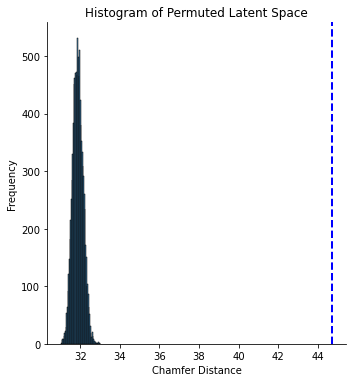

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create histogram with seaborn
sns.displot(permuted_statistics, bins='auto', kde=False)

# Add vertical line at observed statistic
plt.axvline(x=observed_statistic, color='b', linestyle='dashed', linewidth=2)

# Add labels and title
plt.title('Histogram of Permuted Latent Space')
plt.xlabel('Chamfer Distance')
plt.ylabel('Frequency')

# Show plot
plt.show()

In [17]:
print(chamfer_L1_distance(pattern.obsm['latent'], control.obsm['latent']))

44.71541587377258


In [21]:
print(chamfer_L1_distance(random_dict_mixed[0].obsm['latent'], random_dict_mixed[2].obsm['latent']))

34.27557134989247
